### 1) Harvest Data from 'http://www.netd.ac.za/OAI-PMH/'
### 2) Use havested data for University Classification


In [339]:
#Import all the necessary libraries for the project
from IPython.core.interactiveshell import InteractiveShell
import urllib.request
import urllib.parse
import xml.dom.minidom
import operator
from wordcloud import WordCloud
from nltk.corpus import stopwords
import random

import pandas as pd
from xml.dom import minidom
import os
import glob
import matplotlib.pyplot as plt
#%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"


### 1) Create Functions for data harvesting; Harvest the data

In [ ]:

# function for return dom response after parsting oai-pmh URL
def oaipmh_response(URL):
    file = urllib.request.urlopen(URL)
    data = file.read()
    file.close()
 
    dom = xml.dom.minidom.parseString(data) #dom has to be imported somehow
    return dom

# function for getting value of resumptionToken after parsting oai-pmh URL
def oaipmh_resumptionToken(URL):
    file = urllib.request.urlopen(URL)
    data = file.read()
    file.close()
    
    dom = xml.dom.minidom.parseString(data)

    return dom.getElementsByTagName('resumptionToken')[0].firstChild.nodeValue

# function for writing to output files
def write_xml_file(inputData, outputFile):
    oaipmhResponse = open(outputFile, mode="w", encoding = 'utf-8')
    oaipmhResponse.write(inputData)
    oaipmhResponse.close()
    
    
#function for initializing directory for harvesting
def initialize_harvesting_directory():
    base_path = os.path.dirname(os.path.abspath(" "))
    dirName = os.path.join(base_path,"data")
    
    # Create target Directory if don't exist
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")
    
    
# main code

#Initialize directory for harvesting
initialize_harvesting_directory()

baseURL = 'http://www.netd.ac.za/OAI-PMH/'
getRecordsURL = str(baseURL+'?verb=ListRecords&metadataPrefix=oai_dc')
 
# initial parse phase
resumptionToken = oaipmh_resumptionToken(getRecordsURL) # get initial resumptionToken
print ("Resumption Token: "+resumptionToken)
outputFile = 'data/page-0.xml' # define initial file to use for writing response
write_xml_file(oaipmh_response(getRecordsURL).toxml(), outputFile)
 
# loop parse phase
pageCounter = 1
while resumptionToken != "":
    print ("URL ECONDED TOKEN: "+resumptionToken)
    resumptionToken = urllib.parse.urlencode({'resumptionToken':resumptionToken}) # create resumptionToken URL parameter
    print ("Resumption Token: "+resumptionToken)
    getRecordsURLLoop = str(baseURL+'?verb=ListRecords&'+resumptionToken)
    oaipmhXML = oaipmh_response(getRecordsURLLoop).toxml()
    outputFile = 'data/page-'+str(pageCounter) # create file name to use for writing response
    write_xml_file(oaipmhXML, outputFile) # write response to output file
 
    resumptionToken = oaipmh_resumptionToken(getRecordsURLLoop)
    pageCounter += 1 # increament page counter

Directory  /cyberdvd/development/projects/academia/msc/python/jupiter/machine learning/mini-project/data  already exists
Resumption Token: 2014-02-04T16:15:33Z!2037-01-01T00:00:00Z!!oai_dc!1000!177092!oai:union.ndltd.org:ufs/oai:etd.uovs.ac.za:etd-07172013-155725
URL ECONDED TOKEN: 2014-02-04T16:15:33Z!2037-01-01T00:00:00Z!!oai_dc!1000!177092!oai:union.ndltd.org:ufs/oai:etd.uovs.ac.za:etd-07172013-155725
Resumption Token: resumptionToken=2014-02-04T16%3A15%3A33Z%212037-01-01T00%3A00%3A00Z%21%21oai_dc%211000%21177092%21oai%3Aunion.ndltd.org%3Aufs%2Foai%3Aetd.uovs.ac.za%3Aetd-07172013-155725
URL ECONDED TOKEN: 2014-02-04T17:01:29Z!2037-01-01T00:00:00Z!!oai_dc!2000!177092!oai:union.ndltd.org:uwc/oai:UWC_ETD:http%3A%2F%2Fetd.uwc.ac.za%2Findex.php%3Fmodule%3Detd%26action%3Dviewtitle%26id%3Dinit_9308_1173966614
Resumption Token: resumptionToken=2014-02-04T17%3A01%3A29Z%212037-01-01T00%3A00%3A00Z%21%21oai_dc%212000%21177092%21oai%3Aunion.ndltd.org%3Auwc%2Foai%3AUWC_ETD%3Ahttp%253A%252F%252Fet

### 2) Process the harvested data


In [2]:
#Inspect the harvested files to understand their structure
#For now, the fields of interest are setSpec, dc:title,dc:type,dc:date
!head -n 50 data/page-0.xml

<?xml version="1.0" ?><OAI-PMH xmlns="http://www.openarchives.org/OAI/2.0/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/          http://www.openarchives.org/OAI/2.0/OAI-PMH.xsd">
 <responseDate>2019-06-08T11:32:17Z</responseDate>
 <request metadataPrefix="oai_dc" verb="ListRecords">
	http://localhost:8080//OAI-PMH/ </request>
 <ListRecords>
  <record>
<header>
<identifier>oai:union.ndltd.org:nwu/oai:dspace.nwu.ac.za:10394/2920</identifier>
<datestamp>2014-02-04T16:11:35Z</datestamp>
<setSpec>nwu</setSpec>
</header>
<metadata>
<oai_dc:dc xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:oai_dc="http://www.openarchives.org/OAI/2.0/oai_dc/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/oai_dc/ http://www.openarchives.org/OAI/2.0/oai_dc.xsd"><dc:title>The role/status of Information Communication Technology (ICT) in the rural Setlakgobi Area Project Office (APO)

In [170]:
#Create a function that reads the harvested XML files and converts them into a pandas dataframe
def read_xml_files():
    """
    Read the XML files harvested from http://www.netd.ac.za/OAI-PMH/ and convert them into a dataframe for futher analysis
    The dataframe will be restricted to the few columns of concern
    
    Due to time constraints, the insertion date has been taken as the date of publication. The Actual Date of publications needs
    a lot of time to be cleaned up due to the fact that it has been defined as free text, which has led to all sorts of data being entered
        
    """
    dataframe = None
    
    base_path = os.path.dirname(os.path.abspath(" "))
    source_folder = os.path.join(base_path,"data/")

    files = [f for f in glob.glob(source_folder+"page*",recursive=True)]
    var_record_counter = 0
    var_file_counter = 0
    var_etds = []
    var_labels = ["University","Title","Type","Date","Timestamp"]
    
    for f in files:
        xmldoc = minidom.parse(f)
        
        var_file_counter +=1
        
        var_oai_mph = xmldoc.getElementsByTagName("OAI-PMH")[0]
        var_lst_records = var_oai_mph.getElementsByTagName("ListRecords")[0]
        var_records = var_lst_records.getElementsByTagName("record")
        
        
        for record in var_records:
            #print("Retrieve header")
            var_header = record.getElementsByTagName("header")[0]
            var_set_spec = var_header.getElementsByTagName("setSpec")[0].firstChild.data

            #print("*** Retrieve metadata")
            el_metadata = record.getElementsByTagName("metadata")

            var_metadata = el_metadata[0] if len(el_metadata) >0 else None
            var_oai_dc = var_metadata.getElementsByTagName("oai_dc:dc")[0] if var_metadata is not None else None
            if var_oai_dc is not None:
                el_title = var_oai_dc.getElementsByTagName("dc:title")
                if el_title is not None and len(el_title) > 0:
                    var_title_firstChild = el_title[0].firstChild
                    var_oai_title = var_title_firstChild.data if var_title_firstChild is not None else None
                else:
                    var_oai_title = None

                #el_creator = var_oai_dc.getElementsByTagName("dc:creator")
                #var_oai_creator = el_creator[0].firstChild.data if len(el_creator)>0 else None

                #el_subject = var_oai_dc.getElementsByTagName("dc:subject")
                #var_oai_subject = el_subject[0].firstChild.data if len(el_subject) > 0 else None

                #el_description = var_oai_dc.getElementsByTagName("dc:description")
                #var_oai_description = el_description[0].firstChild.data if len(el_description)>0 else None 

                el_date = var_oai_dc.getElementsByTagName("dc:date")
                if el_date is not None and len(el_date)>0:
                    var_el_date_firstChild = el_date[0].firstChild
                    var_oai_date = var_el_date_firstChild.data if var_el_date_firstChild is not None else None
                else:
                    var_oai_date = None

                el_type = var_oai_dc.getElementsByTagName("dc:type")
                if el_type is not None and len(el_type):
                    var_type_firstChild = el_type[0].firstChild
                var_oai_type = var_type_firstChild.data if var_type_firstChild is not None else None
                #var_oai_language = var_oai_dc.getElementsByTagName("dc:language")[0].firstChild.data
            else:
                var_oai_title = None
                var_oai_creator = None
                #var_oai_description = None
                var_oai_date = None
                var_oai_type = None
                #var_oai_language = None


            el_about = record.getElementsByTagName("about")
            if el_about is not None and len(el_about)>0:
                var_about = el_about[0]
                var_provanance = var_about.getElementsByTagName("provenance")[0]
                var_datestamp = var_provanance.getElementsByTagName("datestamp")[0].firstChild.data
            else:
                var_datestamp = None
                
            var_record_counter +=1

            #var_etds.append([var_set_spec,var_oai_title,var_oai_type,var_oai_date])
            var_etds.append([var_set_spec,var_oai_title,var_oai_type,var_oai_date,var_datestamp])



        #    print(var_record_counter,' --> ',var_datestamp ,' : ',var_set_spec,' : ',var_oai_type,':', var_oai_title," : ",var_oai_subject)
        dataframe = pd.DataFrame.from_records(var_etds,columns=var_labels)    


        print("Processed File No. ",var_file_counter," : Records Processed: ",var_record_counter)
        
        
    return dataframe    



In [233]:
#Read the harvested files and convert them to a Pandas Dataframe
df = read_xml_files()

Processed File No.  1  : Records Processed:  1000
Processed File No.  2  : Records Processed:  2000
Processed File No.  3  : Records Processed:  3000
Processed File No.  4  : Records Processed:  4000
Processed File No.  5  : Records Processed:  5000
Processed File No.  6  : Records Processed:  6000
Processed File No.  7  : Records Processed:  7000
Processed File No.  8  : Records Processed:  8000
Processed File No.  9  : Records Processed:  9000
Processed File No.  10  : Records Processed:  10000
Processed File No.  11  : Records Processed:  11000
Processed File No.  12  : Records Processed:  12000
Processed File No.  13  : Records Processed:  13000
Processed File No.  14  : Records Processed:  14000
Processed File No.  15  : Records Processed:  15000
Processed File No.  16  : Records Processed:  16000
Processed File No.  17  : Records Processed:  17000
Processed File No.  18  : Records Processed:  18000
Processed File No.  19  : Records Processed:  19000
Processed File No.  20  : Reco

Processed File No.  157  : Records Processed:  156816
Processed File No.  158  : Records Processed:  157816
Processed File No.  159  : Records Processed:  158816
Processed File No.  160  : Records Processed:  159816
Processed File No.  161  : Records Processed:  160816
Processed File No.  162  : Records Processed:  161816
Processed File No.  163  : Records Processed:  162816
Processed File No.  164  : Records Processed:  163816
Processed File No.  165  : Records Processed:  164816
Processed File No.  166  : Records Processed:  165816
Processed File No.  167  : Records Processed:  166816
Processed File No.  168  : Records Processed:  167816
Processed File No.  169  : Records Processed:  168816
Processed File No.  170  : Records Processed:  169816
Processed File No.  171  : Records Processed:  170816
Processed File No.  172  : Records Processed:  171816
Processed File No.  173  : Records Processed:  172816
Processed File No.  174  : Records Processed:  173816
Processed File No.  175  : R

In [172]:
#Check of null values, if found remove the records
len(df)
df.isna().values.any()
#df.isnull().values.any()

176816

True

In [234]:
def data_cleanup_ingetion():
    """Data cleanup for the dataframe based on the ingestion date"""
    print("Ingestion date based cleanup ")
    len(df)
    cleaned_df=df.dropna()
    len(cleaned_df)
    
    cleaned_df["PublicationDate"] = cleaned_df["Timestamp"].str.split("-",n=1,expand=True)[0]
    cleaned_df.head(3)
    
    return cleaned_df

In [271]:
def data_cleanup_publiction():
    """Data cleanup for the dataframe based on the ingestion date"""
    print("Publication date based cleanup")
    len(df)
    cleaned_df_pub =df.dropna()
    len(cleaned_df_pub)
    
    cleaned_df_pub["PublicationDate"] = cleaned_df_pub["Date"].str.split("-",n=1,expand=True)[0]

    cleaned_df_pub.head(3)
    
    cleaned_df_pub[cleaned_df_pub["PublicationDate"].str.contains('study')] = None
    
    #Drop the Null value that has just been inserted in the PublicationDate, if the above is true
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"].str.contains('ABSTRACT')] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"].str.contains('publication')] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '199u'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '194u'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
     #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '19uu'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '19'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '199'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '198'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '198'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '20'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
  
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '19u2'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '2009.'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '196u'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"].str.contains('XX')] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
 
    cleaned_df_pub["PublicationDate"] = cleaned_df_pub["PublicationDate"].apply(lambda x: x.replace('?',''))
    cleaned_df_pub["PublicationDate"] = cleaned_df_pub["PublicationDate"].apply(lambda x: x.replace('?',''))
    
    cleaned_df_pub["PublicationDate"] = cleaned_df_pub["PublicationDate"].apply(lambda x: x.replace('September ',''))

    cleaned_df_pub["PublicationDate"] = cleaned_df_pub["PublicationDate"].apply(lambda x: x.replace('June ',''))
    
    cleaned_df_pub["PublicationDate"] = cleaned_df_pub["PublicationDate"].apply(lambda x: x.replace('July ',''))
    
    cleaned_df_pub["PublicationDate"] = cleaned_df_pub["PublicationDate"].apply(lambda x: x.replace('[',''))
    
    cleaned_df_pub["PublicationDate"] = cleaned_df_pub["PublicationDate"].apply(lambda x: x.replace(']',''))
    
    cleaned_df_pub["PublicationDate"] = cleaned_df_pub["PublicationDate"].apply(lambda x: x.replace('2016X','2016'))
    
    cleaned_df_pub["PublicationDate"] = cleaned_df_pub["PublicationDate"].apply(lambda x: x.replace('2012/2013','2012'))
    
      #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '20'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    
      #Repeat above process with most common words
    cleaned_df_pub[cleaned_df_pub["PublicationDate"] == '198'] = None
    len(cleaned_df_pub)
    cleaned_df_pub = cleaned_df_pub.dropna()
    len(cleaned_df_pub)
    
    return cleaned_df_pub

In [272]:
cleaned_df = data_cleanup_ingetion()
cleaned_df_pub = data_cleanup_publiction()

Ingestion date based cleanup 


/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Publication date based cleanup


/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [274]:
len(cleaned_df)
cleaned_df["PublicationDate"].unique()

len(cleaned_df_pub)
cleaned_df_pub["PublicationDate"].unique()

132508

array(['2013', '2012', '2014', '2011', '2007', '2018', '2017', '2016',
       '2019', '2015', '2009', '2010', '2004', '2005', '2006', '2008'],
      dtype=object)

132469

array(['2011', '1978', '2012', '2010', '2013', '2008', '2009', '2007',
       '2006', '2014', '2004', '2003', '1993', '2005', '2000', '2001',
       '1997', '1995', '1989', '2018', '2017', '2016', '1992', '1981',
       '1996', '1994', '1991', '1998', '2002', '1999', '1968', '1983',
       '2015', '1982', '1988', '1987', '1984', '1980', '1958', '1963',
       '1955', '1975', '1985', '1990', '1965', '2019', '1986', '1974',
       '1973', '1979', '1961', '1962', '1977', '1932', '1969', '1970',
       '1967', '1976', '1966', '1959', '1960', '1956', '1971', '1954',
       '1952', '1972', '1964', '1953', '1957', '1950', '1951', '1928',
       '1945', '1949', '1946', '1947', '1942', '1938', '1948', '1940',
       '1930', '1926', '1936', '1939'], dtype=object)

In [10]:
#Aggregate data by University and PublicationDate and also just by University
#var_agg_by_univ_by_year = cleaned_df.groupby(['University','PublicationDate']).count()
#var_agg_by_univ = cleaned_df.groupby(['University']).count()
#var_agg_by_year = cleaned_df.groupby(['PublicationDate']).count()

In [105]:
sorted(list(cleaned_df["University"].unique()))

publications = var_agg_by_univ["PublicationDate"]

var_publication_dict = publications.to_dict()
var_publication_dict_sorted = sorted(var_publication_dict.items(),key=operator.itemgetter(0))
var_publication_dict_sorted = dict(var_publication_dict_sorted)

var_etd_ouput = []
for key,val in var_publication_dict_sorted.items():
    print(key,' :: ',val)
    var_etd_ouput.append(val)
    

['cput',
 'cut',
 'dut',
 'nmmu',
 'nwu',
 'rhodes',
 'sun',
 'tut',
 'uct',
 'uctcs',
 'ufh',
 'uj',
 'ukzn',
 'ul',
 'unisa',
 'univen',
 'up',
 'uwc',
 'uzulu',
 'vut',
 'wits',
 'wsu']

cput  ::  1928
cut  ::  651
dut  ::  2581
nmmu  ::  4098
nwu  ::  7670
rhodes  ::  8143
sun  ::  12216
tut  ::  1685
uct  ::  17395
uctcs  ::  101
ufh  ::  1255
uj  ::  9729
ukzn  ::  9528
ul  ::  2348
unisa  ::  16122
univen  ::  993
up  ::  12370
uwc  ::  7121
uzulu  ::  1475
vut  ::  185
wits  ::  15044
wsu  ::  94


In [285]:
def plot_university_etd_total_ouput(cleaned_dataframe,file_output="total_etd.png"):
    """
    Compare the number of publications produced by each university, universally.
    file_output is the name of the file the graph will be saved to
    """
    
    var_aggregation_by_university = cleaned_dataframe.groupby(['University']).count()
    
    universities = cleaned_dataframe["University"].unique()
    var_universities_sorted = sorted(list(universities))
    publications = var_aggregation_by_university["PublicationDate"]

    var_publication_dict = publications.to_dict()
    var_publication_dict_sorted = sorted(var_publication_dict.items(),key=operator.itemgetter(0))
    var_publication_dict_sorted = dict(var_publication_dict_sorted)

    #Extract the output ordered by university name in ascending order
    var_etd_ouput = []
    for key,val in var_publication_dict_sorted.items():
        var_etd_ouput.append(val)

    plt.style.use("ggplot")
    plt.plot(var_universities_sorted,var_etd_ouput)
    plt.xlabel("University")
    plt.ylabel("Number of ETDs Published")
    plt.title("Total ETDs Published")
    plt.xticks(rotation=90)
    plt.savefig(file_output,bbox_inches='tight')
    plt.show()


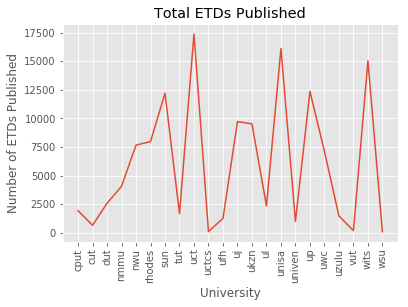

In [286]:
# Plot total etd ouput by universities, Ingestion date based
plot_university_etd_total_ouput(cleaned_df,"total_etd_ingestion_date.png")

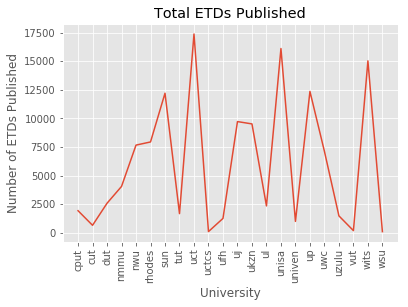

In [287]:
# Plot total etd ouput by universities, Publication date based
plot_university_etd_total_ouput(cleaned_df_pub,"total_etd_pub_date.png")

In [288]:
def bar_plot_university_etd_total_ouput(cleaned_dataframe,file_output="total_etd_barh.png"):
    """
    Compare the number of publications produced by each university, universally
    by means of a horizontal bar
    file_output is the name of the file the bar is plotted on
    """ 
    var_colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "black", "blue", "green", "red", "cyan", "magenta", "yellow", "black", "blue","gray"]

    var_aggregation_by_university = cleaned_dataframe.groupby(['University']).count()
    
    universities = cleaned_dataframe["University"].unique()
    var_universities_sorted = sorted(list(universities))
    publications = var_aggregation_by_university["PublicationDate"]

    var_publication_dict = publications.to_dict()
    var_publication_dict_sorted = sorted(var_publication_dict.items(),key=operator.itemgetter(0))
    var_publication_dict_sorted = dict(var_publication_dict_sorted)

        #Extract the output ordered by university name in ascending order
    var_etd_ouput = []
    for key,val in var_publication_dict_sorted.items():
        var_etd_ouput.append(val)

    fig = plt.figure(figsize=(15,10))
    axes = fig.add_axes([0.1,0.1,0.8,0.8])
    axes.barh(var_universities_sorted,var_etd_ouput,color=var_colors)
    plt.style.use("ggplot")
    plt.ylabel("University")
    plt.xlabel("Number of ETDs Published")
    plt.title("Total ETDs Published")
    plt.xticks(rotation=90)
    plt.savefig(file_output,bbox_inches='tight')
    plt.show()

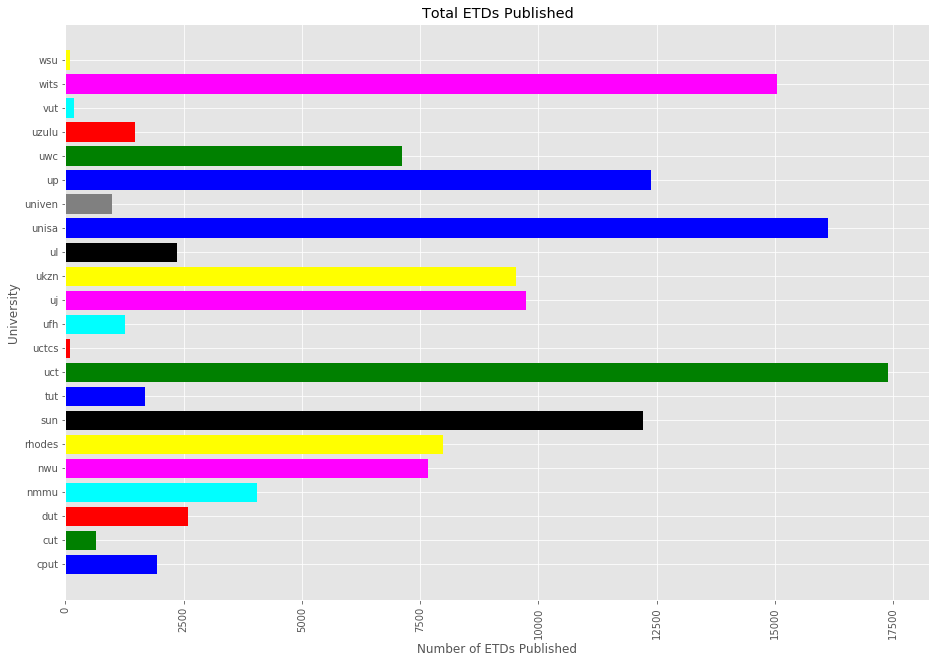

In [289]:
bar_plot_university_etd_total_ouput(cleaned_df)

In [295]:
#cleaned_df_pub[["University","Type","PublicationDate"]]

In [114]:
!open .

In [301]:
def plot_university_etd_oupupt_year_by_year(cleaned_dataframe,file_output="etd-by-year-by-univ.png"):
    #Lets now compute university publications by year
    cleaned_df_trimmed = cleaned_dataframe[["University","Type","PublicationDate"]]
    cleaned_df_trimmed.groupby(['University','PublicationDate'])['Type'].size().plot(kind='barh',figsize=(5,100))
    #cleaned_dataframe.groupby(['University','PublicationDate'])['Title'].nunique().plot(kind='line',figsize=(20,5))
    #plt.ylabel=("No. ETDs published")
    plt.savefig(file_output,bbox_inches='tight')
    plt.show()

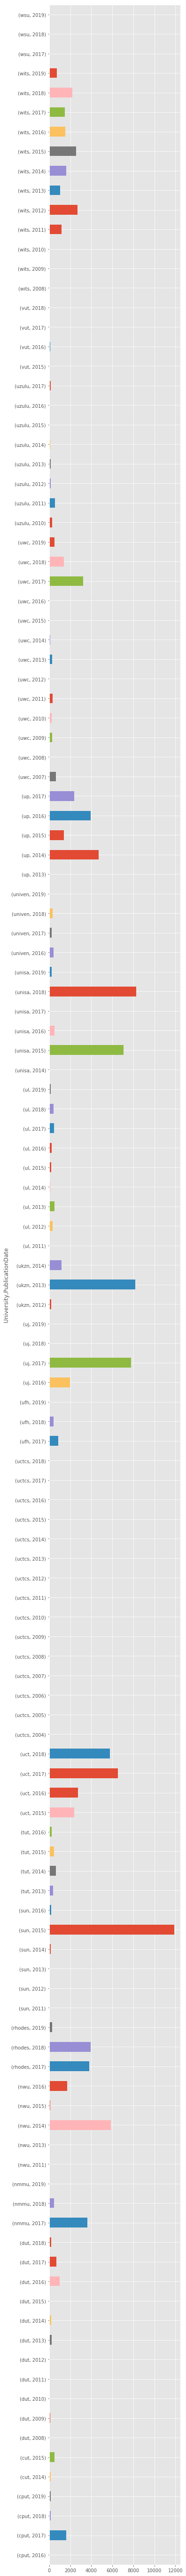

In [302]:
#University output year by year, based on date of ingestion
plot_university_etd_oupupt_year_by_year(cleaned_df,file_output="etd-by-year-by-univ_ingestion.png")

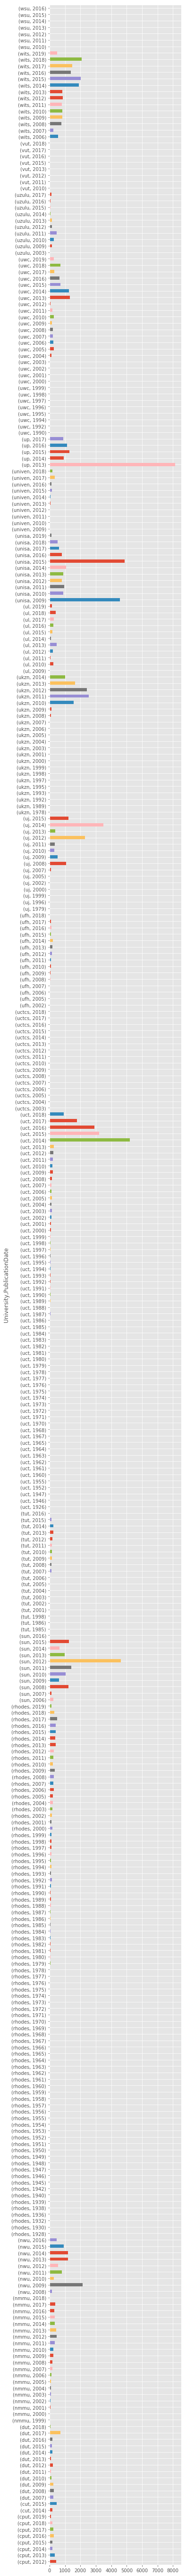

In [303]:
#University output year by year, based on date of publication date
plot_university_etd_oupupt_year_by_year(cleaned_df_pub,file_output="etd-by-year-by-univ_publication.png")

In [346]:
#Show general ETD publication trends
def plot_edt_ouput_trends_by_year(cleaned_dataframe,width=10,height=7,file_output="etd-trend-year_scatter.png"):
    
    var_university_ets_by_year = cleaned_dataframe.groupby(['PublicationDate']).count()
    number_of_colors = len(var_university_ets_by_year)
    var_university_ets_by_year = var_university_ets_by_year["Title"]
    
    #var_colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "black", "blue", "green", "red", "cyan", "magenta", "yellow", "black", "blue","gray"]

    var_colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
    
    x=[]
    y=[]
    for key,val in var_university_ets_by_year.items():
        x.append(key)
        y.append(val)

    fig = plt.figure(figsize=(width,height))
    axes = fig.add_axes([0.1,0.1,0.8,0.8])
    axes.scatter(x,y,c=var_colors,alpha=0.5)    
    plt.style.use("ggplot")
    
    plt.xlabel('Years')
    plt.ylabel('ETD publications')
    plt.title('Total ETD ouputs Year by Year')
    plt.xticks(rotation=90)
    plt.savefig(file_output,bbox_inches='tight')
    plt.show()
    


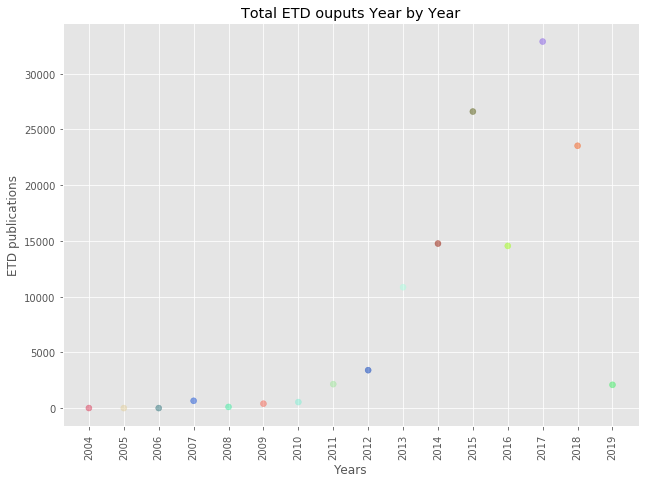

In [347]:
#Plot ETD output trends based on ingestion date
plot_edt_ouput_trends_by_year(cleaned_df,file_output="etd-trend-year_scatter_ingestion.png")

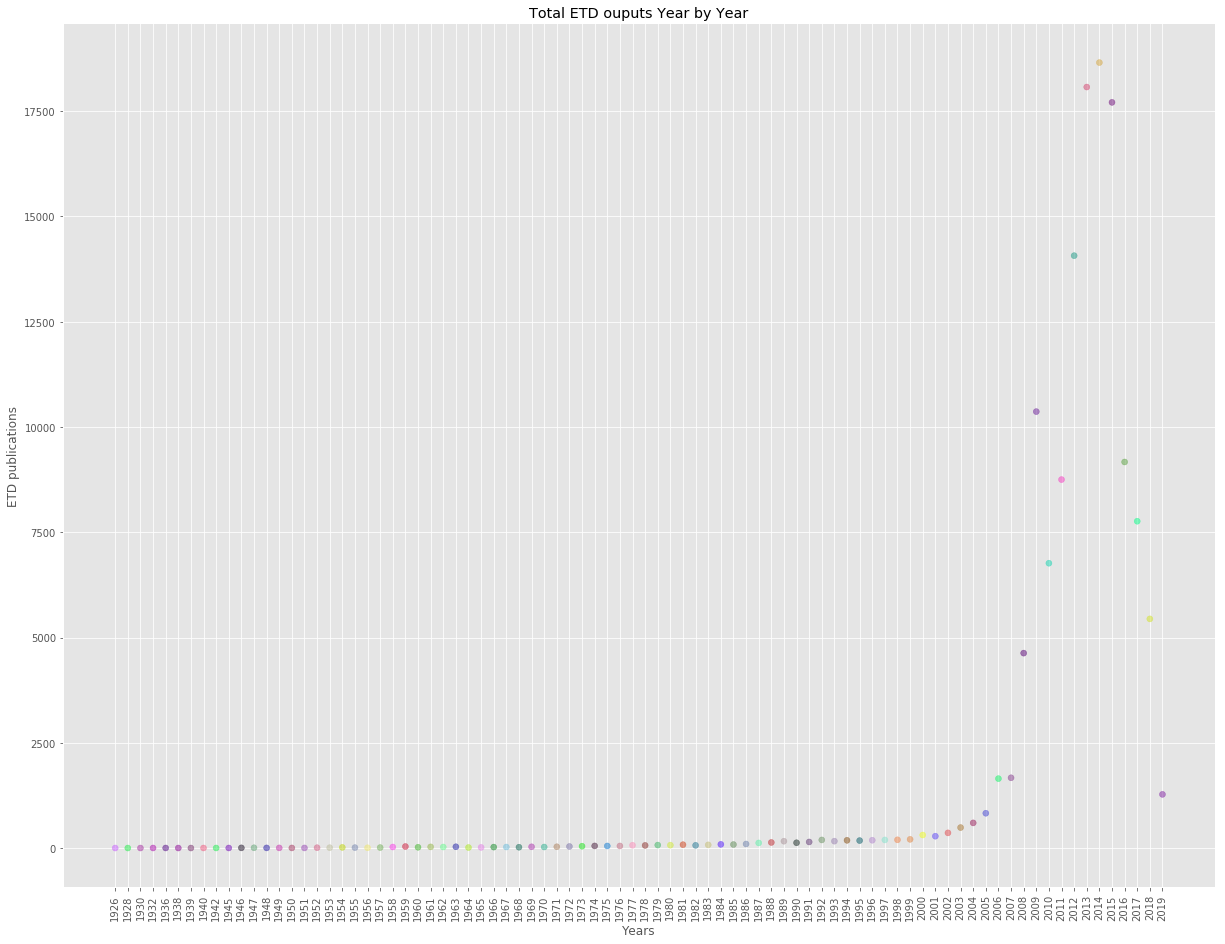

In [348]:
#Plot ETD output trends based on publication date
plot_edt_ouput_trends_by_year(cleaned_df_pub,width=20,height=15,file_output="etd-trend-year_scatter_publication.png")

In [382]:
var_university_ets_by_year = cleaned_df.groupby(['University']).count()
#var_university_ets_by_year["Title"]["cput"]
var_univ_by_pub = dict(cleaned_df.groupby(['University','PublicationDate']).size())
var_univ_by_pub

{('cput', '2016'): 16,
 ('cput', '2017'): 1630,
 ('cput', '2018'): 157,
 ('cput', '2019'): 125,
 ('cut', '2014'): 136,
 ('cut', '2015'): 515,
 ('dut', '2008'): 28,
 ('dut', '2009'): 93,
 ('dut', '2010'): 33,
 ('dut', '2011'): 28,
 ('dut', '2012'): 22,
 ('dut', '2013'): 240,
 ('dut', '2014'): 169,
 ('dut', '2015'): 62,
 ('dut', '2016'): 1012,
 ('dut', '2017'): 694,
 ('dut', '2018'): 200,
 ('nmmu', '2017'): 3611,
 ('nmmu', '2018'): 434,
 ('nmmu', '2019'): 10,
 ('nwu', '2011'): 5,
 ('nwu', '2013'): 4,
 ('nwu', '2014'): 5869,
 ('nwu', '2015'): 79,
 ('nwu', '2016'): 1713,
 ('rhodes', '2017'): 3804,
 ('rhodes', '2018'): 3917,
 ('rhodes', '2019'): 256,
 ('sun', '2011'): 3,
 ('sun', '2012'): 1,
 ('sun', '2013'): 25,
 ('sun', '2014'): 149,
 ('sun', '2015'): 11871,
 ('sun', '2016'): 166,
 ('tut', '2013'): 367,
 ('tut', '2014'): 643,
 ('tut', '2015'): 440,
 ('tut', '2016'): 222,
 ('uct', '2015'): 2359,
 ('uct', '2016'): 2714,
 ('uct', '2017'): 6545,
 ('uct', '2018'): 5777,
 ('uctcs', '2004'): 8,


In [391]:
def prepare_etds_by_year_dict(cleaned_dataframe):
    var_univ_dict = {}
    var_publication_dates_sorted = list(cleaned_dataframe["PublicationDate"].unique())
    var_publication_dates_sorted.sort()

    var_universities = list(cleaned_dataframe["University"].unique())
    var_universities.sort()
    
    var_university_ets_by_year = cleaned_dataframe.groupby(['University']).count()

    var_univ_by_pub = dict(cleaned_dataframe.groupby(['University','PublicationDate']).size())
    
    counter = 0

    for university in var_universities:
        counter += 1

        var_edt_output = []
        for year in var_publication_dates_sorted: 
            #Check if val is in. If exsists, fetch the etd output, append to list else append a zero  
            if (university,year) in var_univ_by_pub:
                #fetch
                #var_edt_output.append(var_university_ets_by_year[(university,year)])
                var_edt_output.append(var_univ_by_pub[(university,year)])
            else:
                var_edt_output.append(0)

        var_univ_dict[university] = var_edt_output

    #    if counter == 5:
    #        break
    return var_univ_dict
        


In [390]:
var_univ_dict = prepare_etds_by_year_dict(cleaned_df)
var_univ_dict

{'cput': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 1630, 157, 125],
 'cut': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 515, 0, 0, 0, 0],
 'dut': [0, 0, 0, 0, 28, 93, 33, 28, 22, 240, 169, 62, 1012, 694, 200, 0],
 'nmmu': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3611, 434, 10],
 'nwu': [0, 0, 0, 0, 0, 0, 0, 5, 0, 4, 5869, 79, 1713, 0, 0, 0],
 'rhodes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3804, 3917, 256],
 'sun': [0, 0, 0, 0, 0, 0, 0, 3, 1, 25, 149, 11871, 166, 0, 0, 0],
 'tut': [0, 0, 0, 0, 0, 0, 0, 0, 0, 367, 643, 440, 222, 0, 0, 0],
 'uct': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2359, 2714, 6545, 5777, 0],
 'uctcs': [8, 4, 3, 10, 6, 7, 9, 8, 6, 8, 12, 10, 2, 1, 7, 0],
 'ufh': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 845, 405, 4],
 'uj': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1953, 7769, 4, 3],
 'ukzn': [0, 0, 0, 0, 0, 0, 0, 0, 195, 8174, 1159, 0, 0, 0, 0, 0],
 'ul': [0, 0, 0, 0, 0, 0, 0, 27, 306, 505, 91, 173, 226, 445, 424, 151],
 'unisa': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 7055, 506, 21, 8252, 

In [396]:
#Plot ETDs Publications Year by Year
def plot_university_etd_output_by_year(cleaned_dataframe,width=15,height=10,file_output="etd-trend-year.png"):
    var_colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "black", "blue", "green", "red", "cyan", "magenta", "yellow", "black", "blue","gray"]
    var_univ_dict = prepare_etds_by_year_dict(cleaned_dataframe)
    var_publication_dates_sorted = list(cleaned_dataframe["PublicationDate"].unique())
    var_publication_dates_sorted.sort()


    fig = plt.figure(figsize=(width,height))
    axes = fig.add_axes([0.1,0.1,0.8,0.8])
    for key,val in var_univ_dict.items():
        axes.plot(var_publication_dates_sorted,val,label=key)

    plt.title('ETD Publication Year by Year')
    plt.ylabel('ETD Ouptput')
    plt.xlabel('Years')
    plt.xticks(rotation=90)
    plt.legend(loc='best')
    plt.savefig(file_output,bbox_inches='tight')
    plt.show()

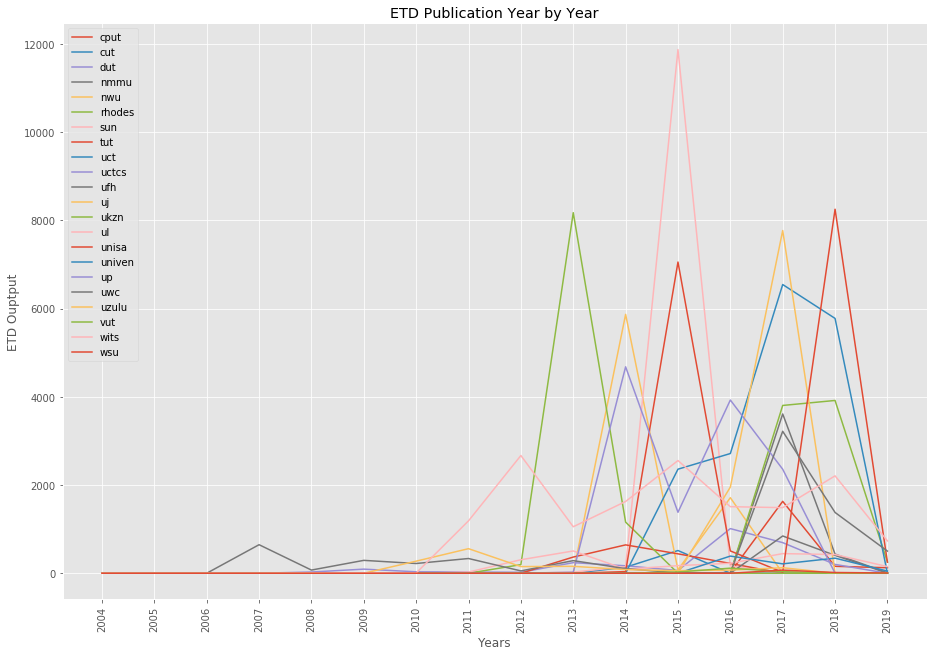

In [393]:
plot_university_etd_output_by_year(cleaned_df,file_output="etd-trend-year-ingestion.png")

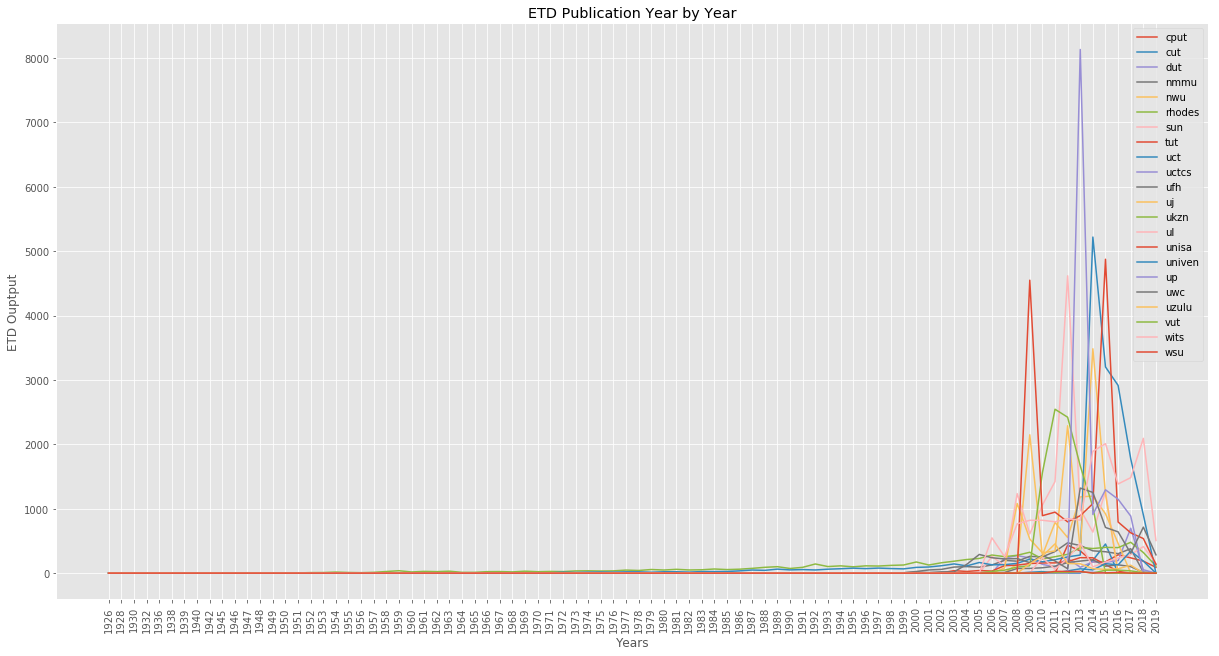

In [397]:
plot_university_etd_output_by_year(cleaned_df_pub,width=20,height=10,file_output="etd-trend-year-publication.png")

<Figure size 1080x720 with 0 Axes>

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

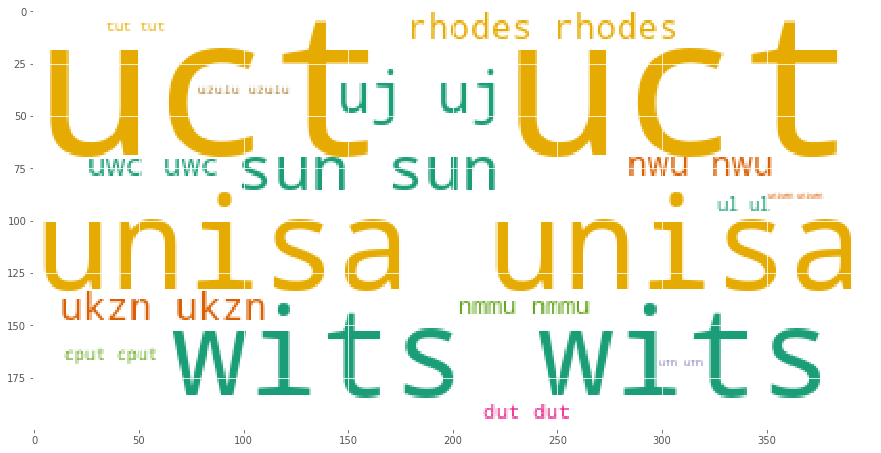

In [21]:
#print a word cloud on Univiversity 
var_university_etd_output_wordcloud = WordCloud(stopwords=stopwords.words("english"),background_color="white",colormap="Dark2",max_font_size=150,random_state=42)
var_university_etd_output = cleaned_df["University"]
var_university_etd_output_wordcloud.generate(' '.join(var_university_etd_output))

plt.figure(figsize=(15,10))
var_university_etd_output_wordcloud.to_file("word_cloud_etd_output_by_university.png")
plt.imshow(var_university_etd_output_wordcloud)
plt.axes("off")

In [72]:
help(WordCloud)

Help on class WordCloud in module wordcloud.wordcloud:

class WordCloud(builtins.object)
 |  WordCloud(font_path=None, width=400, height=200, margin=2, ranks_only=None, prefer_horizontal=0.9, mask=None, scale=1, color_func=None, max_words=200, min_font_size=4, stopwords=None, random_state=None, background_color='black', max_font_size=None, font_step=1, mode='RGB', relative_scaling='auto', regexp=None, collocations=True, colormap=None, normalize_plurals=True, contour_width=0, contour_color='black', repeat=False)
 |  
 |  Word cloud object for generating and drawing.
 |  
 |  Parameters
 |  ----------
 |  font_path : string
 |      Font path to the font that will be used (OTF or TTF).
 |      Defaults to DroidSansMono path on a Linux machine. If you are on
 |      another OS or don't have this font, you need to adjust this path.
 |  
 |  width : int (default=400)
 |      Width of the canvas.
 |  
 |  height : int (default=200)
 |      Height of the canvas.
 |  
 |  prefer_horizontal : fl

In [22]:
var_univ_dict = {}
var_publication_dates_sorted = list(cleaned_df["PublicationDate"].unique())
var_publication_dates_sorted.sort()

counter = 0
for key,val in var_univ_by_pub:
    #var_univ_by_pub[(key,val)] ==> Value or Total
    #key = University
    #val = Year
    
    var_inner_dict = {}
    var_inner_dict[val]=var_univ_by_pub[(key,val)]

    if key in var_univ_dict:
        #Already defined, retrieve value(dictionary), and append
        var_temp = {}
        var_temp[key] = 
        var_current_dict = var_univ_dict[key]
        var_current_dict.update(var_inner_dict)
    else:
        #Insert new key, value(dictionary)
        var_univ_dict[key] = None
    
    if counter == 10:
        break
    #print('key : ',key, ' val = ',val, 'total:',var_univ_by_pub[(key,val)])

SyntaxError: invalid syntax (<ipython-input-22-6a456fb8c2ad>, line 17)

In [68]:
type(cleaned_df_trimmed.groupby(['University','PublicationDate']).size())

pandas.core.series.Series

In [371]:
dict(cleaned_df.groupby(['University','PublicationDate']).size())
var_univ_by_pub

{('cput', '2016'): 16,
 ('cput', '2017'): 1630,
 ('cput', '2018'): 157,
 ('cput', '2019'): 125,
 ('cut', '2014'): 136,
 ('cut', '2015'): 515,
 ('dut', '2008'): 28,
 ('dut', '2009'): 93,
 ('dut', '2010'): 33,
 ('dut', '2011'): 28,
 ('dut', '2012'): 22,
 ('dut', '2013'): 240,
 ('dut', '2014'): 169,
 ('dut', '2015'): 62,
 ('dut', '2016'): 1012,
 ('dut', '2017'): 694,
 ('dut', '2018'): 200,
 ('nmmu', '2017'): 3611,
 ('nmmu', '2018'): 434,
 ('nmmu', '2019'): 10,
 ('nwu', '2011'): 5,
 ('nwu', '2013'): 4,
 ('nwu', '2014'): 5869,
 ('nwu', '2015'): 79,
 ('nwu', '2016'): 1713,
 ('rhodes', '2017'): 3804,
 ('rhodes', '2018'): 3917,
 ('rhodes', '2019'): 256,
 ('sun', '2011'): 3,
 ('sun', '2012'): 1,
 ('sun', '2013'): 25,
 ('sun', '2014'): 149,
 ('sun', '2015'): 11871,
 ('sun', '2016'): 166,
 ('tut', '2013'): 367,
 ('tut', '2014'): 643,
 ('tut', '2015'): 440,
 ('tut', '2016'): 222,
 ('uct', '2015'): 2359,
 ('uct', '2016'): 2714,
 ('uct', '2017'): 6545,
 ('uct', '2018'): 5777,
 ('uctcs', '2004'): 8,


{('cput', '2016'): 16,
 ('cput', '2017'): 1630,
 ('cput', '2018'): 157,
 ('cput', '2019'): 125,
 ('cut', '2014'): 136,
 ('cut', '2015'): 515,
 ('dut', '2008'): 28,
 ('dut', '2009'): 93,
 ('dut', '2010'): 33,
 ('dut', '2011'): 28,
 ('dut', '2012'): 22,
 ('dut', '2013'): 240,
 ('dut', '2014'): 169,
 ('dut', '2015'): 62,
 ('dut', '2016'): 1012,
 ('dut', '2017'): 694,
 ('dut', '2018'): 200,
 ('nmmu', '2017'): 3654,
 ('nmmu', '2018'): 434,
 ('nmmu', '2019'): 10,
 ('nwu', '2011'): 5,
 ('nwu', '2013'): 4,
 ('nwu', '2014'): 5869,
 ('nwu', '2015'): 79,
 ('nwu', '2016'): 1713,
 ('rhodes', '2017'): 3848,
 ('rhodes', '2018'): 4035,
 ('rhodes', '2019'): 260,
 ('sun', '2011'): 3,
 ('sun', '2012'): 1,
 ('sun', '2013'): 25,
 ('sun', '2014'): 149,
 ('sun', '2015'): 11872,
 ('sun', '2016'): 166,
 ('tut', '2013'): 378,
 ('tut', '2014'): 643,
 ('tut', '2015'): 441,
 ('tut', '2016'): 223,
 ('uct', '2015'): 2359,
 ('uct', '2016'): 2714,
 ('uct', '2017'): 6545,
 ('uct', '2018'): 5777,
 ('uctcs', '2004'): 8,


In [69]:
var_univ_by_pub[('cput', '2016')]

16

In [84]:
cleaned_df_trimmed.groupby(['University','PublicationDate'])['Type'].size()["uctcs"]

PublicationDate
2004     8
2005     4
2006     3
2007    10
2008     6
2009     7
2010     9
2011     8
2012     6
2013     8
2014    12
2015    10
2016     2
2017     1
2018     7
Name: Type, dtype: int64

In [86]:
len(cleaned_df["University"].unique())

22

['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']


In [91]:
temp_dict = {}

In [92]:
temp_dict[1]='David'

In [93]:
temp_dict

{1: 'David'}

In [95]:
temp_dict[1]

'David'

In [97]:
1 in temp_dict

True

In [98]:
temp_dict2 = {3:'Mulenga'}

In [105]:
temp_dict.update(temp_dict2)

In [106]:
temp_dict

{1: 'David', 3: 'Mulenga'}

In [103]:
print(temp_dict2)

{3: 'Mulenga'}


In [123]:
4 in temp_dict2

False

{1: 'David', 3: 'Mulenga'}

In [126]:

var_universities

['cput',
 'cut',
 'dut',
 'nmmu',
 'nwu',
 'rhodes',
 'sun',
 'tut',
 'uct',
 'uctcs',
 'ufh',
 'uj',
 'ukzn',
 'ul',
 'unisa',
 'univen',
 'up',
 'uwc',
 'uzulu',
 'vut',
 'wits',
 'wsu']

In [127]:
for i in var_universities:
    print(i)

cput
cut
dut
nmmu
nwu
rhodes
sun
tut
uct
uctcs
ufh
uj
ukzn
ul
unisa
univen
up
uwc
uzulu
vut
wits
wsu


In [141]:
temp_dict3={'david':100,'mulenga':90,'chilekwa':95,'katongo':40,'bwalya':98}

In [149]:
import operator
sorted_dict = sorted(temp_dict3.items(),key=operator.itemgetter(1))

#key=operator.itemgetter(1) 1== Value, 0 == Key

In [148]:
sorted_dict

[('katongo', 40),
 ('mulenga', 90),
 ('chilekwa', 95),
 ('bwalya', 98),
 ('david', 100)]

In [25]:
var_agg_by_univ_by_year

Title  Type  Date
University PublicationDate                   
cput       2016                16    16    16
           2017              1630  1630  1630
           2018               157   157   157
           2019               125   125   125
cut        2014               136   136   136
           2015               515   515   515
dut        2008                28    28    28
           2009                93    93    93
           2010                33    33    33
           2011                28    28    28
           2012                22    22    22
           2013               240   240   240
           2014               169   169   169
           2015                62    62    62
           2016              1012  1012  1012
           2017               694   694   694
           2018               200   200   200
nmmu       2017              3654  3654  3654
           2018               434   434   434
           2019                10    10    10
nwu        2011                 5     5     5
           2013                 4     4     4
           2014              5869  5869  5869
           2015                79    79    79
           2016              1713  1713  1713
rhodes     2017              3848  3848  3848
           2018              4035  4035  4035
           2019               260   260   260
sun        2011                 3     3     3
           2012                 1     1     1
...                           ...   ...   ...
uwc        2017              3218  3218  3218
           2018              1378  1378  1378
           2019               502   502   502
uzulu      2010               274   274   274
           2011               557   557   557
           2012               151   151   151
           2013               157   157   157
           2014                82    82    82
           2015                58    58    58
           2016                71    71    71
           2017               125   125   125
vut        2015                29    29    29
           2016               115   115   115
           2017                36    36    36
           2018                 5     5     5
wits       2008                 3     3     3
           2009                 6     6     6
           2010                 5     5     5
           2011              1188  1188  1188
           2012              2669  2669  2669
           2013              1054  1054  1054
           2014              1627  1627  1627
           2015              2555  2555  2555
           2016              1509  1509  1509
           2017              1487  1487  1487
           2018              2208  2208  2208
           2019               733   733   733
wsu        2017                71    71    71
           2018                17    17    17
           2019                 6     6     6

[131 rows x 3 columns]

In [23]:
cleaned_df.columns

Index(['University', 'Title', 'Type', 'Date', 'PublicationDate'], dtype='object')

In [35]:
!open .

[('wsu', 94),
 ('uctcs', 101),
 ('vut', 185),
 ('cut', 651),
 ('univen', 993),
 ('ufh', 1255),
 ('uzulu', 1475),
 ('tut', 1685),
 ('cput', 1928),
 ('ul', 2348),
 ('dut', 2581),
 ('nmmu', 4098),
 ('uwc', 7121),
 ('nwu', 7670),
 ('rhodes', 8143),
 ('ukzn', 9528),
 ('uj', 9729),
 ('sun', 12216),
 ('up', 12370),
 ('wits', 15044),
 ('unisa', 16122),
 ('uct', 17395)]

{'wsu': 94,
 'uctcs': 101,
 'vut': 185,
 'cut': 651,
 'univen': 993,
 'ufh': 1255,
 'uzulu': 1475,
 'tut': 1685,
 'cput': 1928,
 'ul': 2348,
 'dut': 2581,
 'nmmu': 4098,
 'uwc': 7121,
 'nwu': 7670,
 'rhodes': 8143,
 'ukzn': 9528,
 'uj': 9729,
 'sun': 12216,
 'up': 12370,
 'wits': 15044,
 'unisa': 16122,
 'uct': 17395}

In [34]:
#cleaned_df.groupby("University").count()[["Type","PublicationDate"]].to_csv("test.csv")
cleaned_df.groupby("University").count()[["Type","PublicationDate"]]

,Type,PublicationDate
University,,
cput,1928,1928
cut,651,651
dut,2581,2581
nmmu,4098,4098
nwu,7670,7670
rhodes,8143,8143
sun,12216,12216
tut,1685,1685
uct,17395,17395


In [58]:
#var_agg_by_univ["PublicationDate"]
#cleaned_df["University"].unique()

publications = var_agg_by_univ["PublicationDate"]
    
    #order the results by value for a more organized visualization
var_publication_dict = publications.to_dict()
var_publication_dict_sorted = sorted(var_publication_dict.items(),key=operator.itemgetter(0))
var_publication_dict_sorted = dict(var_publication_dict_sorted)
var_publication_dict_sorted

{'cput': 1928,
 'cut': 651,
 'dut': 2581,
 'nmmu': 4098,
 'nwu': 7670,
 'rhodes': 8143,
 'sun': 12216,
 'tut': 1685,
 'uct': 17395,
 'uctcs': 101,
 'ufh': 1255,
 'uj': 9729,
 'ukzn': 9528,
 'ul': 2348,
 'unisa': 16122,
 'univen': 993,
 'up': 12370,
 'uwc': 7121,
 'uzulu': 1475,
 'vut': 185,
 'wits': 15044,
 'wsu': 94}

In [338]:
import random
number_of_colors = 84

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
print(color)

['#C5B859', '#5A9551', '#9E9B5A', '#95DA01', '#7D00C6', '#DD9B5C', '#E7126E', '#816263', '#5DCA85', '#BDDD46', '#3039F6', '#744E52', '#370AAB', '#989245', '#EE75A3', '#480D6A', '#9A7DB5', '#C2DD05', '#CCE78F', '#D89A81', '#5CE4F0', '#90EBF2', '#D11FA7', '#500AC5', '#7CA94B', '#35FBF7', '#E3AC8C', '#A36223', '#073E4C', '#7AC90C', '#E5C906', '#D95786', '#B398A6', '#9CF70F', '#64B8E0', '#992DCD', '#A05506', '#DE8D73', '#6B3422', '#538ADD', '#E8C2F9', '#97FA8B', '#A634D9', '#B0C516', '#082B30', '#B9C873', '#40DFB5', '#C25A27', '#9ACB36', '#2B9D12', '#A7A84E', '#44242C', '#535A5A', '#F088FC', '#B43F2A', '#9D01A3', '#5221D4', '#2E7FD3', '#80EB81', '#97A9EE', '#6AD9C0', '#E8190A', '#8DCCAA', '#F8DE9E', '#C3FB6D', '#C42D78', '#00AB4B', '#6E93B1', '#2B750E', '#C43A3C', '#DCF7AE', '#3422AF', '#F3D6C3', '#C6BF45', '#AAD39D', '#586710', '#F917DB', '#EC6354', '#A14799', '#C5C862', '#5FE195', '#9FF388', '#0521C3', '#EFA41A']
